# Step 1. Scope-1 GHG emissions from CDP
The 2016 edition of the CDP emissions dataset (D<sup>CDP2016</sup>) provides annual mean GHG emissions in CO2 equivalents from 187 cities. Reported emissions categories include Scope 1 being the direct territorial emissions from residential and industrial heating, transport, industrial sectors, Scope 2 being emissions from purchased energy generated upstream from the city, mainly electricity, and Total Emissions, nominally equal to the sum of Scope 1 and Scope 2. 

Here, emission data in D<sup>CDP2016</sup> are checked for inconsistencies and replaced by a more recent version of the CDP data called D<sup>CDP2017</sup>. Based on this quality control procedure, quality flags are assigned to the GHG Scope-1 emissions of each city.

**Emissions Quality Flags (EQFs)**

**A** = TOT = S1 + S2 (within 15% tolerance) or TOT can be derived by summing scopes  
**B** = S3 included in total, but TOT = S1 + S2. Both cannot be true.  
**C** = S1 exists, S2 missing (3 cities), or in S2 exists, S1 missing (later derived) (6 cities)  
**D** = both scopes are missing
**E** = S1 exists, S2 missing, and TOT = S1 + S2 = S1. S1 likely correct therefore TOT is incomplete.

In [1]:
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import pandas as pd
import collections
from collections import Counter
import os

import csv

In [4]:
pd.set_option('display.max_colwidth', -1)

In [5]:
pd.__version__

u'0.22.0'

In [6]:
np.version.version

'1.14.0'

In [7]:
matplotlib.__version__

'2.1.2'

In [8]:
csv.__version__

'1.0'

# Variables

In [9]:
var_account = 'Account Number'

var_city2016 = 'City Short Name (CDP2016)'
var_city2017 = 'City (CDP2017)'
var_country = 'Country (CDP2016)'

var_pop2016 = 'Current Population (CDP2016)'
var_popyr2016 = 'Current Population Year (CDP2016)'

var_pop2017 = 'Population (CDP2017)'
var_popyr2017 = 'Population year (CDP2017)'

var_bd2016 = 'Boundary (CDP2016)'
var_bd2017 = 'Boundary (CDP2017)'

var_yr2016 = 'Measurement year only (CDP2016)'
var_yr2017 = 'Measurement year only (CDP2017)'

var_protocol2016 = 'Primary Methodology (CDP2016)'
var_protocol2017 = 'Protocol (CDP2017)'

#Emissions
var_tot2016 = 'Total City-wide Emissions (metric tonnes CO2e) (CDP2016)'
var_s1_2016 = 'Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016)'
var_s2_2016 = 'Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016)'

var_tot2017 = 'Total emissions (metric tonnes CO2e) (CDP2017)'
var_s1_2017 = 'Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017)'
var_s2_2017 = 'Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017)'

var_sf2016 = 'scope fraction (CDP2016)'
var_sf2017 = 'scope fraction (CDP2017)'

var_gases2016 = 'Gases included (CDP2016)'
var_gases2017 = 'Gases included (CDP2017)'

var_incScopes = 'Scopes Included (CDP2017)'

str_scopesAll = 'Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)'
str_scopesTwo = 'Total Scope 1 and Scope 2'

var_forgiveness = 0.15  #tolerance given for sum check
var_eqf = 'Emissions Quality Flag'


# Functions

In [10]:
def tag_column_names_with_datasetname(df, tagname):
    """ Add to column name dataset from which column was obtained"""
    
    col_names = list(df)
    
    for cname in col_names:
        if cname != 'Account Number':
            df.rename(columns = {cname:cname + ' (' + tagname + ')'}, inplace = True)
    
    
    return df

## Case checks

In [11]:
# Case 1: TOT = s1 OR s2
# a) both scopes exist

def fn_case1a(df, var_s1, var_s2, var_tot):
    """ Check if tot = s1 OR s2, where BOTH scopes exist.
    Ignore cities that have already been checked.
    Action: Assume total is incorrect. Recalculate total by summing the scopes."""
    
    case1a = (
        (~df[var_s1].isnull()) & (~df[var_s2].isnull()) 
        & (df[var_tot] == df[var_s1]) | (df[var_tot] == df[var_s2])
        & (df['CDP2016 data edited'].isnull()) 
    )     
    
    return case1a

In [12]:
# Case 1: TOT = s1 OR s2
# a) s1 OR s2 exists

def fn_case1b(df, var_s1, var_s2, var_tot):
    """ Check if tot = s1 OR s2, where EITHER scope1 or scope2 exists. 
    Ignore cities that have already been checked.
    Action: Check CDP2017, if that doesn't resolve it, nothing can be done."""
    
    case1b = (
        (df[var_tot] == df[var_s1]) | (df[var_tot] == df[var_s2]) 
        & ( (~df[var_s1].isnull()) | (~df[var_s2].isnull())  )
        & (df['CDP2016 data edited'].isnull())  
    )
    
    return case1b

In [13]:
# Case 2: TOT = s1 + s2
# Tolerable (WITHIN FORGIVENESS RANGE): 1 - var_forgiveness < scope fraction < 1 + var_forgiveness

def fn_case2_tolerable(df, var_s1, var_s2, var_tot, var_sf):
    """ Check if tot < (s1+s2) within the forgiveness factor.
    Ignore cities that have already been checked.
    Action for CDP2016: See if CDP2017 has useable values when scope fraction is near the extremes. 
    If not, leave as is."""
       
    case2_tolerable = (   
        (df[var_tot] != df[[var_s1, var_s2]].sum(axis=1) ) 
        & (df['CDP2016 data edited'].isnull() )
        & ( (1 - var_forgiveness) < df[var_sf] ) & ( df[var_sf] < (1 + var_forgiveness)  )
    )
    
    return case2_tolerable

In [14]:
# Case 3: TOT != s1 + s2
# a) Intolerable (OUTSIDE FORGIVENESS RANGE): 
# scope fraction < 1 - var_forgiveness OR scope fraction > 1 + var_forgiveness

def fn_case3a_intolerable(df, var_s1, var_s2, var_tot, var_sf):
    """ Check if tot << (s1+s2) by more than forgiveness factor.
    Ignore cities that have already been checked.
    Action for CDP2016: See if CDP2017 has useable values. If not, flag for CDP to check."""
    
    case3a_intolerable = (   
        (df[var_tot] != df[[var_s1, var_s2]].sum(axis=1) ) 
        & (df['CDP2016 data edited'].isnull() )
        & ( df[var_sf] < (1 - var_forgiveness) ) | ( df[var_sf] > (1 + var_forgiveness)  )
    )
    
    return case3a_intolerable

In [15]:
# Case 3
# b) Intolerable: TOT < s1 OR s2 (NO FORGIVENESS) 

def fn_case3b_intolerable(df, var_s, var_tot):
    """ Check if tot < s_i, no forgiveness
    Ignore cities that have already been checked.
    Action for CDP2016: Flag for CDP to check."""
    
    case3b_intolerable = (   
        (df[var_tot] < df[var_s] )
        & (df['CDP2016 data edited'].isnull() )  
    )

    return case3b_intolerable

In [16]:
# Case 4: 
# a) One scope missing, the other exists

def fn_case4a_fixable(df, var_s_missing, var_s_exists):
    """ Check if s1 missing, s2 exists.
    Ignore cities that have already been checked.
    Action: Calculate s1 by s1 = TOT - s2."""
    
    case4a_fixable = (
        (df[var_s_missing].isnull()) & (~df[var_s_exists].isnull()) 
        & (df['CDP2016 data edited'].isnull()) 
    )     
    
    return case4a_fixable

In [17]:
# Case 4
# b) both s1 and s2 are missing

def fn_case4b(df, var_s1, var_s2):
    """ Check if both scopes are missing.
    Ignore cities that have already been checked.
    Action: See if CDP2017 has useable values. If that doesn't resolve it, nothing can be done."""
    
    case4b = (
        (df[var_s1].isnull()) & (df[var_s2].isnull()) 
        & (df['CDP2016 data edited'].isnull()) 
    )     
    
    return case4b

### For replacing CDP2016 data by CDP2017

In [18]:
list2016 = ['Reporting Year (CDP2016)', 'Measurement Year (CDP2016)', 'Measurement year only (CDP2016)',
            'Boundary (CDP2016)', 'Primary Methodology (CDP2016)', 'Methodology Details (CDP2016)', 
            'Gases included (CDP2016)', 'Total City-wide Emissions (metric tonnes CO2e) (CDP2016)',
            'Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016)', 
            'Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016)',
            'Increase/Decrease from last year (CDP2016)', 
            'Reason for increase/decrease in emissions (CDP2016)', 
            'Current Population (CDP2016)', 'Current Population Year (CDP2016)', 'scope fraction (CDP2016)'
           ]


list2017 = ['Reporting year (CDP2017)', 'Accounting year (CDP2017)', 'Measurement year only (CDP2017)',
            'Boundary (CDP2017)', 'Protocol (CDP2017)', 'Comment (CDP2017)',
            'Gases included (CDP2017)', 'Total emissions (metric tonnes CO2e) (CDP2017)',
            'Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017)',
            'Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017)',
            'Increase/Decrease from last year (CDP2017)',
            'Reason for increase/decrease in emissions (CDP2017)',
            'Population (CDP2017)', 'Population year (CDP2017)', 'scope fraction (CDP2017)'
           ]

def fn_replace2016(df, condition, replaceReason, list2016, list2017):
    """ Replaces values in list2016 columns with values from list2017 columns"""
       
    idx=0
    for colname in list2016:
        df.loc[condition, colname] = df[list2017[idx]]
        idx = idx + 1
    
    df.loc[condition, 'CDP2016 data edited'] = 'Replaced by CDP2017 data. Reason: ' + replaceReason
    
    return df

# Read data

## Updated CDP2016 (containing scopes)
https://data.cdp.net/Cities/2016-Citywide-GHG-Emissions/dfed-thx7/data

In [19]:
fname = 'DATA/ORIGINAL_EMISSIONS_SOURCEFILES/2016_-_Citywide_GHG_Emissions_updatedDec2017_formatted.csv'

df_scopes = pd.read_csv(fname)

In [20]:
df_scopes.head(2)

,Account Number,City Name,Country,City Short Name,C40,Reporting Year,Measurement Year,Boundary,Primary Methodology,Methodology Details,...,Current Population,City GDP,GDP Currency,Year of GDP,GDP Source,Average annual temperature (in Celsius)​,​Land area (in square km),Average altitude (m),City Location,Country Location
0,54650,Prefeitura de Palmas,Brazil,Palmas,NaN,2016,12/31/2013 12:00:00 AM,A metropolitan area,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)",O diagnóstico qualitativo das informações complementa a avaliação quantitativa.,...,272726.0,899887.0,BRL Brazilian Real,2016.0,NaN,NaN,NaN,NaN,"(-10.249091, -48.324286)","(-14.235004, -51.92528)"
1,59996,Batangas City,Philippines,Batangas,NaN,2016,12/20/2010 12:00:00 AM,A metropolitan area,2006 IPCC Guidelines for National Greenhouse Gas Inventories,NaN,...,332458.0,NaN,PHP Philippine Peso,NaN,NaN,25.0,285.0,10.0,"(13.756465, 121.058308)","(12.879721, 121.774017)"


In [21]:
df_scopes.shape

(187, 27)

In [22]:
df_scopes.loc[df_scopes['City Short Name'] == 'Rotterdam', ['City Short Name', 'Total City-wide Emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', 'Gases included']]

,City Short Name,Total City-wide Emissions (metric tonnes CO2e),Total Scope 1 Emissions (metric tonnes CO2e),Total Scope 2 Emissions (metric tonnes CO2e),Gases included
95,Rotterdam,31512000.0,30011000.0,1501000.0,CO2


### Manually adjust Aspen and Pitkin County values

The emission values to use are:  

TOT = 394,341 tCO2 and erase S1 and S2 values.

In [23]:
df_scopes.loc[df_scopes['City Short Name'] == 'Aspen and Pitkin County', ['City Short Name', 'Total City-wide Emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', 'Gases included']]

,City Short Name,Total City-wide Emissions (metric tonnes CO2e),Total Scope 1 Emissions (metric tonnes CO2e),Total Scope 2 Emissions (metric tonnes CO2e),Gases included
132,Aspen and Pitkin County,394341.0,341208.0,136413.0,CO2; CH4; N2O


In [24]:
df_scopes.loc[df_scopes['City Short Name'] == 'Aspen and Pitkin County', 'Total Scope 1 Emissions (metric tonnes CO2e)'] = np.nan
df_scopes.loc[df_scopes['City Short Name'] == 'Aspen and Pitkin County', 'Total Scope 2 Emissions (metric tonnes CO2e)'] = np.nan

In [25]:
#Check:
df_scopes.loc[df_scopes['City Short Name'] == 'Aspen and Pitkin County', ['City Short Name', 'Total City-wide Emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', 'Gases included']]

,City Short Name,Total City-wide Emissions (metric tonnes CO2e),Total Scope 1 Emissions (metric tonnes CO2e),Total Scope 2 Emissions (metric tonnes CO2e),Gases included
132,Aspen and Pitkin County,394341.0,NaN,NaN,CO2; CH4; N2O


In [26]:
df_scopes.rename(columns = {'Average annual temperature (in Celsius)\xe2\x80\x8b':'Average annual temperature (in Celsius)'}, inplace = True)
df_scopes.rename(columns = {'\xe2\x80\x8bLand area (in square km)':'Land area (in square km)'}, inplace = True)

### Add formatted Measurement year column to df_scopes

In [27]:
#First change to datetime format
df_scopes['Measurement Year'] = pd.to_datetime(df_scopes['Measurement Year'])

In [28]:
#Create new column, extracting only year from 'Measurement year' column
df_scopes['Measurement year only'] = df_scopes['Measurement Year'].dt.year

In [29]:
tag_column_names_with_datasetname(df_scopes, 'CDP2016')
list(df_scopes)

['Account Number',
 'City Name (CDP2016)',
 'Country (CDP2016)',
 'City Short Name (CDP2016)',
 'C40 (CDP2016)',
 'Reporting Year (CDP2016)',
 'Measurement Year (CDP2016)',
 'Boundary (CDP2016)',
 'Primary Methodology (CDP2016)',
 'Methodology Details (CDP2016)',
 'Gases included (CDP2016)',
 'Total City-wide Emissions (metric tonnes CO2e) (CDP2016)',
 'Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016)',
 'Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016)',
 'Increase/Decrease from last year (CDP2016)',
 'Reason for increase/decrease in emissions (CDP2016)',
 'Current Population Year (CDP2016)',
 'Current Population (CDP2016)',
 'City GDP (CDP2016)',
 'GDP Currency (CDP2016)',
 'Year of GDP (CDP2016)',
 'GDP Source (CDP2016)',
 'Average annual temperature (in Celsius) (CDP2016)',
 'Land area (in square km) (CDP2016)',
 'Average altitude (m) (CDP2016)',
 'City Location (CDP2016)',
 'Country Location (CDP2016)',
 'Measurement year only (CDP2016)']

## CDP 2017
https://data.cdp.net/Cities/2017-Cities-Community-Wide-Emissions/kyi6-dk5h/data

In [30]:
fname = 'DATA/ORIGINAL_EMISSIONS_SOURCEFILES/2017_-_Cities_Community_Wide_Emissions_updatedDec2017_formatted.csv'

df_2017 = pd.read_csv(fname)

In [31]:
df_2017.rename(columns = {'Account number':'Account Number'}, inplace = True)

#white space
df_2017.rename(columns = {'Scopes Included ':'Scopes Included'}, inplace = True)

In [32]:
#Extract measurement year only
df_2017['Accounting year'] = pd.to_datetime(df_2017['Accounting year'])
df_2017['Measurement year only'] = df_2017['Accounting year'].dt.year

### Manually adjust Rotterdam CDP2017 values

Scope 1 emissions excluding emissions from grid-supplied energy generation are 17,840,039 metric tonnes CO2e.  
Remove Scope 2 value since they do not include eneregy generation.

In [33]:
df_2017.loc[df_2017['City'] == 'Rotterdam', ['City', 'Total emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', 'Gases included']]

,City,Total emissions (metric tonnes CO2e),Total Scope 1 Emissions (metric tonnes CO2e),Total Scope 2 Emissions (metric tonnes CO2e),Gases included
220,Rotterdam,34190633.0,32619756.0,1570877.0,CO2


In [34]:
df_2017.loc[df_2017['City'] == 'Rotterdam', 'Total Scope 1 Emissions (metric tonnes CO2e)'] = 17840039
df_2017.loc[df_2017['City'] == 'Rotterdam', 'Total Scope 2 Emissions (metric tonnes CO2e)'] = np.nan

In [35]:
#Check:
df_2017.loc[df_2017['City'] == 'Rotterdam', ['City', 'Total emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', var_eqf,'Gases included']]

/homel/cnangini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/homel/cnangini/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,City,Total emissions (metric tonnes CO2e),Total Scope 1 Emissions (metric tonnes CO2e),Total Scope 2 Emissions (metric tonnes CO2e),Emissions Quality Flag,Gases included
220,Rotterdam,34190633.0,17840039.0,NaN,NaN,CO2


In [36]:
tag_column_names_with_datasetname(df_2017, 'CDP2017')
print df_2017.shape

(229, 24)


# Combine CDP2016 data with CDP2017
=> There are 153 cities in common between 2016 and 2017 

In [37]:
#First merge 2016 and 2017 on same city, then filter for common cities and for same measurement year
print df_scopes.shape
print df_2017.shape

df_merge = pd.merge(df_scopes, df_2017, on='Account Number', how='outer')
print df_merge.shape

(187, 28)
(229, 24)
(263, 51)


# Extract CDP2016 cities only from the merge

In [38]:
#Extract from merge CDP cities only
df_venn = df_merge[df_merge['Account Number'].isin(df_scopes['Account Number'])]
df_venn.shape

(187, 51)

In [39]:
#Number of CDP2016 cities in CDP2017 => 153
print 'Number of CDP2017 cities in CDP2017: ' + repr(df_venn.loc[~df_venn[var_tot2017].isnull(), var_city2016].count())

Number of CDP2017 cities in CDP2017: 153


# QA/QC on CDP2016 data
Look if cities with large scope discord in 2016 can be replaced by 2017 data
where large discord is defined as Scope1 + Scope2 != total by > 15%  

NB!!! In CDP2017, Tot Emissions is not necessarily just scope1 + scope2. There could be more, e.g.:  

df_venn['Scopes Included  (CDP2017)'][5] = 'Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)'

In [40]:
df_venn.loc[ (~df_venn[var_s1_2016].isnull()) & (~df_venn[var_s2_2016].isnull()), ['City Short Name (CDP2016)', var_s1_2016, var_s2_2016] ]

,City Short Name (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016)
0,Palmas,589055.31,36336.28
1,Batangas,344419.00,107239.00
2,Okayama,114000.00,6802000.00
4,"Alton, IL",138542.00,262537.00
5,Eugene,1106250.00,137500.00
6,Cape Town,9783734.00,12860112.00
7,Bogotá,10679585.14,1094791.71
9,Durban,11681810.00,10905271.00
10,"Portland, OR",4610317.00,2364227.00
17,Paris,3359242.00,1836421.00


## Define the Scope Fraction
scope fraction = (Scope_1 + Scope_2)/total

In [41]:
#scope fraction for CDP2016 
df_venn.loc[ (~df_venn[var_s1_2016].isnull()) & (~df_venn[var_s2_2016].isnull()), 'scope fraction (CDP2016)'] = (df_venn[var_s1_2016] + df_venn[var_s2_2016])/df_venn[var_tot2016]  #.round(2)

/homel/cnangini/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/homel/cnangini/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
#scope fraction for CDP2017
df_venn.loc[ (~df_venn[var_s1_2017].isnull()) & (~df_venn[var_s2_2017].isnull()), 'scope fraction (CDP2017)'] = ((df_venn[var_s1_2017] + df_venn[var_s2_2017])/df_venn[var_tot2017]).round(2)

In [43]:
print df_venn.shape

(187, 53)


In [44]:
df_venn = df_venn.sort_values('scope fraction (CDP2016)', ascending=False)

In [45]:
df_venn[[var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes]].head(6)

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017)
124,Pingtung,4604805.0,3.704683e+10,1.435430e+10,4969246.69,2768427.4,2200856.14,11162.499957,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
79,Lima,15432105.0,1.237873e+07,1.543210e+07,2868080.00,12688756.0,3919620.00,1.802142,5.79,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
61,Lahti,685460.0,9.221200e+05,1.236800e+05,717200.00,717200.0,157607.00,1.525691,1.22,Total Scope 1 and Scope 2
105,Cascais,565382.0,5.653820e+05,2.662210e+05,565382.00,565382.0,266221.00,1.470869,1.47,Total Scope 1 and Scope 2
33,Región Metropolitana de Santiago,23120027.8,2.312003e+07,8.306669e+06,28406420.00,18030830.0,10375589.00,1.359285,1.00,Total Scope 1 and Scope 2
89,Ljubljana,2079758.0,1.829808e+06,9.040420e+05,2733850.00,1829808.0,904042.00,1.314504,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"


## Case 1. CDP2016 TOT == scope1 OR scope2

### Case 1a.  both scopes exist

In [46]:
#Initialize column to keep track of edits made to CDP2016 data
df_venn['CDP2016 data edited'] = np.nan

In [47]:
currentCondition = fn_case1a(df_venn, var_s1_2016, var_s2_2016, var_tot2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ]

#=> 4 cities satisfy Case 1.

4


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
79,Lima,15432105.0,12378734.0,15432105.0,2868080.0,12688756.0,3919620.0,1.802142,5.79,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
105,Cascais,565382.0,565382.0,266221.0,565382.0,565382.0,266221.0,1.470869,1.47,Total Scope 1 and Scope 2,NaN
33,Región Metropolitana de Santiago,23120027.8,23120027.8,8306669.0,28406420.0,18030830.0,10375589.0,1.359285,1.00,Total Scope 1 and Scope 2,NaN
35,Windsor,2475703.0,2475703.0,6709.0,1074018.0,1775831.0,109527.0,1.002710,1.76,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN


### Action for Case 1a
* Assume the total is incorrect. Recalculate total by summing scopes.  
* Re-calculate scope fraction based on new total.  
* Add a note in new column 'CDP2016 data edited' to keep track of all modified data

In [48]:
df_venn.loc[currentCondition, var_tot2016] = df_venn[[var_s1_2016, var_s2_2016]].sum(axis=1)
df_venn.loc[currentCondition, var_sf2016] = df_venn[[var_s1_2016, var_s2_2016]].sum(axis=1)/df_venn[var_tot2016]
df_venn.loc[currentCondition, 'CDP2016 data edited'] = 'Case 1a: re-calculated CDP2016 TOT by summing CDP2016 s1+s2'

In [49]:
df_venn.loc[currentCondition, [var_city2016, var_sf2016, var_tot2016,var_s1_2016,var_s2_2016, 'CDP2016 data edited']]

,City Short Name (CDP2016),scope fraction (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),CDP2016 data edited
79,Lima,1.0,27810839.0,12378734.0,15432105.0,Case 1a: re-calculated CDP2016 TOT by summing CDP2016 s1+s2
105,Cascais,1.0,831603.0,565382.0,266221.0,Case 1a: re-calculated CDP2016 TOT by summing CDP2016 s1+s2
33,Región Metropolitana de Santiago,1.0,31426696.8,23120027.8,8306669.0,Case 1a: re-calculated CDP2016 TOT by summing CDP2016 s1+s2
35,Windsor,1.0,2482412.0,2475703.0,6709.0,Case 1a: re-calculated CDP2016 TOT by summing CDP2016 s1+s2


### Conclusion for Case 1a
* all 4 cities that pass this check have been resolved

In [50]:
#Record changes in 'CDP2016 data edited' column
df_venn.loc[currentCondition, 'CDP2016 data edited'] = (
    'CDP2016 TOT recalculated by summing both CDP2016 scopes.'
)

In [51]:
#Assign Emisisons Quality Flag
df_venn.loc[currentCondition, 'Emissions Quality Flag'] = 'A'

### Case 1b.  TOT = s1 OR s2, only one of the scopes exist

In [52]:
currentCondition = fn_case1b(df_venn, var_s1_2016, var_s2_2016, var_tot2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ]

9


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
56,Bogor,2193642.0,2193642.0,NaN,2193642.0,954020.0,1239622.0,NaN,1.0,Total Scope 1 and Scope 2,NaN
58,Addis Ababa,3708292.0,3708292.0,NaN,3708292.0,3708292.0,NaN,NaN,NaN,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
66,Reykjavík,346630.0,346630.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Vilnius,1994560.0,1994560.0,NaN,1944330.0,1944329.0,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN
90,Lagos,29426266.0,29426266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,"Davis, CA",348437.0,348437.0,NaN,348437.0,348437.0,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN
164,Nashville and Davidson,12275845.0,12275845.0,NaN,12481363.0,6680194.0,5801169.0,NaN,1.0,"Total Scope 1, Scope 2 (Total BASIC emissions)",NaN
168,Palo Alto,152631.0,152631.0,NaN,153948.0,153948.0,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN
183,Brasília,7739830.0,7739830.0,NaN,7739830.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN


### Action for Case 1b
* For 2 cities (Bogor; Nashville and Davidson) where sf2017 = 1.0, can replace with CDP2017. Note that Scopes Included (CDP2017) does not have Scope 3, so the TOT makes sense. Assign Emissions Quality Flag A
* Assume that TOT is wrong for remaining 7 cities because missing scope is 0 => EQF E. Therefore leave as is. Especially as CDP2017 replacement candidate values either do not exist, have the same problem, or include Scope 3...

In [53]:
replaceReason = (
    ' TOT = s1, s2 does not exist (Case 1b) in CDP2016. Soln: Replace with CDP2017 values' \
    ' (TOT, s1 and s2)'
)

fn_replace2016(
    df_venn, df_venn[var_city2016].str.contains('Bogor'), replaceReason, list2016, list2017
)

fn_replace2016(
    df_venn, df_venn[var_city2016].str.contains('Nashville'), replaceReason, list2016, list2017
)

#Assign Emissions Quality Flag (EQF) A
df_venn.loc[df_venn[var_city2016].str.contains('Bogor'), 'Emissions Quality Flag'] = 'A'
df_venn.loc[df_venn[var_city2016].str.contains('Nashville'), 'Emissions Quality Flag'] = 'A'

#Check
df_venn.loc[df_venn[var_city2016].str.contains('Bogor'), 
            [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2016,
             var_sf2017,var_tot2017, 
             var_s1_2017, var_s2_2017,'CDP2016 data edited', 'Emissions Quality Flag']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited,Emissions Quality Flag
56,Bogor,2193642.0,954020.0,1239622.0,1.0,1.0,2193642.0,954020.0,1239622.0,"Replaced by CDP2017 data. Reason: TOT = s1, s2 does not exist (Case 1b) in CDP2016. Soln: Replace with CDP2017 values (TOT, s1 and s2)",A


In [54]:
#Check
df_venn.loc[df_venn[var_city2016].str.contains('Nashville'), 
            [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2016,
             var_sf2017,var_tot2017, 
             var_s1_2017, var_s2_2017,'CDP2016 data edited', 'Emissions Quality Flag']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited,Emissions Quality Flag
164,Nashville and Davidson,12481363.0,6680194.0,5801169.0,1.0,1.0,12481363.0,6680194.0,5801169.0,"Replaced by CDP2017 data. Reason: TOT = s1, s2 does not exist (Case 1b) in CDP2016. Soln: Replace with CDP2017 values (TOT, s1 and s2)",A


### Add Emissions Quality Flag
EQF E: TOT is not the total since one scope is missing.

In [55]:
df_venn.loc[currentCondition & (df_venn[var_sf2016].isnull()),'Emissions Quality Flag'] = 'E'

In [56]:
#Make note in 'CDP2016 data edited' column
df_venn.loc[currentCondition & (df_venn[var_sf2016].isnull()), 'CDP2016 data edited'] = (
    'CDP2016 TOT likely wrong because one scope is missing.'
)

In [57]:
#Check
df_venn.loc[df_venn['Emissions Quality Flag']=='E', 
            [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2016,
             var_sf2017,var_tot2017, 
             var_s1_2017, var_s2_2017,'CDP2016 data edited', 'Emissions Quality Flag']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited,Emissions Quality Flag
58,Addis Ababa,3708292.0,3708292.0,NaN,NaN,NaN,3708292.0,3708292.0,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
66,Reykjavík,346630.0,346630.0,NaN,NaN,NaN,NaN,NaN,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
88,Vilnius,1994560.0,1994560.0,NaN,NaN,NaN,1944330.0,1944329.0,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
90,Lagos,29426266.0,29426266.0,NaN,NaN,NaN,NaN,NaN,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
133,"Davis, CA",348437.0,348437.0,NaN,NaN,NaN,348437.0,348437.0,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
168,Palo Alto,152631.0,152631.0,NaN,NaN,NaN,153948.0,153948.0,NaN,CDP2016 TOT likely wrong because one scope is missing.,E
183,Brasília,7739830.0,7739830.0,NaN,NaN,NaN,7739830.0,NaN,NaN,CDP2016 TOT likely wrong because one scope is missing.,E


## Case 2. CDP2016 TOT = (scope1 + scope2) within forgiveness range
Exclude cities that have already been investigated (column 'CDP2016 data edited' not null).

In [58]:
currentCondition = fn_case2_tolerable(df_venn, var_s1_2016, var_s2_2016, var_tot2016, var_sf2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ].head(4)

33


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
84,Suwon,5775155.00,3670140.00,2710235.00,NaN,NaN,NaN,1.104797,NaN,NaN,NaN
120,Lausanne,499573.00,456843.00,45730.00,NaN,NaN,NaN,1.006005,NaN,NaN,NaN
186,Zaragoza,1785603.75,1175162.74,613341.01,1785603.750,1175162.74,613341.01,1.001624,1.0,Total Scope 1 and Scope 2,NaN
106,Faro,265.85,128.00,138.00,246.331,104.00,143.00,1.000564,1.0,Total Scope 1 and Scope 2,NaN


In [59]:
#How much within tolerance are these 33 cities?
df_venn.loc[currentCondition, [var_city2016, var_sf2016]].sort_values(var_sf2016)

,City Short Name (CDP2016),scope fraction (CDP2016)
139,Houston,0.914997
7,Bogotá,0.952672
38,Salvador,0.975560
102,Madrid,0.979461
1,Batangas,0.987688
176,San Francisco,0.988066
172,St Louis,0.992139
116,Iowa,0.993070
5,Eugene,0.995000
126,"Hermosa Beach, CA",0.999534


### Conclusion for Case 2
Of the 33 cities that pass Case 2 check:  
* The scope fraction for all ranges from 0.91-1.10 for the 29 cities that pass this check, therefore leave as is.

In [60]:
#Check where TOT == S1+S2 exactly
def fn_case2_exact(df, var_s1, var_s2, var_tot, var_sf):
    """ Check if tot == (s1+s2) exactly.
    Ignore cities that have already been checked."""
       
    case2_exact = (   
        (df[var_tot] == df[[var_s1, var_s2]].sum(axis=1) ) 
        & (df['CDP2016 data edited'].isnull() )
    )
    
    return case2_exact

In [61]:
currentCondition = fn_case2_exact(df_venn, var_s1_2016, var_s2_2016, var_tot2016, var_sf2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, 
                               var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 
                               'CDP2016 data edited'] ].head(4)

76


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
34,Udine,613588.00,438005.00,175583.0,613588.00,438005.0,175583.00,1.0,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
142,"Arlington, VA",2480700.00,1257464.00,1223236.0,279743.00,1239302.0,1273559.00,1.0,8.98,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
137,Dallas,17229388.00,119881.00,17109507.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
136,Flagstaff,1211617.47,621293.07,590324.4,1424562.96,949707.2,474855.76,1.0,1.00,Total Scope 1 and Scope 2,NaN


In [62]:
df_venn.loc[df_venn[var_city2016]=='Rotterdam', [var_city2016, var_tot2016,var_tot2017,var_s1_2016, var_s1_2017,var_s2_2016, var_s2_2017,'CDP2016 data edited',var_eqf]]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited,Emissions Quality Flag
95,Rotterdam,31512000.0,34190633.0,30011000.0,17840039.0,1501000.0,NaN,NaN,NaN


In [63]:
replaceReason = (
    ' TOT = s1, s2 does not exist (Case 1b) in CDP2016. Soln: Replace with CDP2017 values' \
    ' (TOT, s1 and s2)'
)

fn_replace2016(
    df_venn, df_venn[var_city2016].str.contains('Bogor'), replaceReason, list2016, list2017
)

,Account Number,City Name (CDP2016),Country (CDP2016),City Short Name (CDP2016),C40 (CDP2016),Reporting Year (CDP2016),Measurement Year (CDP2016),Boundary (CDP2016),Primary Methodology (CDP2016),Methodology Details (CDP2016),...,Reason for increase/decrease in emissions (CDP2017),Population (CDP2017),Population year (CDP2017),City Location (CDP2017),Country Location (CDP2017),Measurement year only (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),CDP2016 data edited,Emissions Quality Flag
124,57347,Pingtung County Government,Taiwan,Pingtung,NaN,2016.0,2013-12-31 00:00:00,Administrative boundary of a local government,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)",NaN,...,"The main increased department are energy, industry, and waste",835792.0,2016.0,"(22.6558, 120.4703)","(23.69781, 120.960515)",2013.0,11162.499957,1.00,NaN,NaN
79,31170,Metropolitan Municipality of Lima,Peru,Lima,C40,2016.0,2012-12-31 00:00:00,A metropolitan area,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)","La metodología Global Protocol for Community- scale Greenhouse Gas emissions (GPC) establece que los límites pueden definirse en cualquiera de tres niveles: Internacional, inter-ciudades/subnacional, o al interior de la ciudad.",...,Han aumentado puesto que no se ha trabajado en proyectos o programas que tengan gran potencial de reducción en gases con efecto invernadero.,8755262.0,2014.0,"(-12.046374, -77.042793)","(-9.189967, -75.015152)",2015.0,1.000000,5.79,CDP2016 TOT recalculated by summing both CDP2016 scopes.,A
61,54402,City of Lahti,Finland,Lahti,NaN,2016.0,2013-12-31 00:00:00,Administrative boundary of a local government,2006 IPCC Guidelines for National Greenhouse Gas Inventories,With some national modifications,...,Decreased from baseline year 1990. New waste gasification plant 2012 and collecting separate energy waste from citizens. Effective waste water treatment with collecting biogas before composting the sludge. Effective and energy-efficient waste and biowaste collection and treatment (new biogas plant 2014). Better energy effiency in buildings.,119452.0,2016.0,"(60.9833, 25.65)","(61.92411, 25.748151)",2015.0,1.525691,1.22,NaN,NaN
105,50680,Cascais,Portugal,Cascais,NaN,2016.0,2010-12-31 00:00:00,Administrative boundary of a local government,2006 IPCC Guidelines for National Greenhouse Gas Inventories,"this was made with calculous platforms from international organizations such as UN (IPCC, and ICLEI) as well as EU comission",...,We have verified a decrease in fuel consumption between the mentioned time period.,208122.0,2014.0,"(38.6970565, -9.4222945)","(39.399872, -8.224454)",2010.0,1.000000,1.47,CDP2016 TOT recalculated by summing both CDP2016 scopes.,A
33,31180,Región Metropolitana de Santiago,Chile,Región Metropolitana de Santiago,C40,2016.0,2013-12-31 00:00:00,A metropolitan area,2006 IPCC Guidelines for National Greenhouse Gas Inventories,"GPC was used for organizing information, while for the estimation of emissions (equations and emission factors) the IPCC guidelines was used.",...,"The emissions has decreased 1% respect year 2012. There was a significant decrease in the energy industry emissions, however it was counteracted by an increase in the transport sector.",6527903.0,2012.0,"(-33.44889, -70.669265)","(-35.675147, -71.542969)",2013.0,1.000000,1.00,CDP2016 TOT recalculated by summing both CDP2016 scopes.,A
89,43920,City of Ljubljana,Slovenia,Ljubljana,NaN,2016.0,2014-12-31 00:00:00,Administrative boundary of a local government,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)","The difference that occurs in emissions (between C1.4 and C1.5) is a result of different emissions counting from electricity consumption as required by the COM. Check the XLS REPORT: Table B. Summary - I.4.4 Energy supplied to the grid is informal only - not summed in the total e

In [64]:
#Add Emissions Quality Flag
df_venn.loc[currentCondition, 'Emissions Quality Flag'] = 'A'

## Case 3. CDP2016 TOT != (scope1 + scope2) outside forgiveness range [INTOLERABLE]
Exclude cities that have already been investigated (column 'CDP2016 data edited' not null).

### Case 3a.  TOT >> or << s1 + s2
(1-var_forgiveness) < scope fraction < (1+var_forgiveness)  
where scope fraction defined as (s1+s2)/TOT

In [65]:
currentCondition = fn_case3a_intolerable(df_venn, var_s1_2016, var_s2_2016, var_tot2016, var_sf2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ].head(4)

13


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
124,Pingtung,4604805.0,3.704683e+10,1.435430e+10,4969246.69,2768427.4,2200856.14,11162.499957,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
61,Lahti,685460.0,9.221200e+05,1.236800e+05,717200.00,717200.0,157607.00,1.525691,1.22,Total Scope 1 and Scope 2,NaN
89,Ljubljana,2079758.0,1.829808e+06,9.040420e+05,2733850.00,1829808.0,904042.00,1.314504,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
177,Santa Monica,705443.0,3.025100e+05,2.412530e+05,334591.00,119026.0,215565.00,0.770811,1.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN


### Action for Case 3a
* See if CDP2017 has useable values</sup>*</sup>.

<sup>*</sup>When evaluating CDP2017 values, they must pass all the above checks, plus additional checks if Waste Scope 3: s3 cannot be > 15% than the total emissions; s3 != s1 OR s2; s3 << s1 + s2...

In [66]:
#Number of cities in CDP2017
print df_venn.loc[currentCondition & (~df_venn[var_tot2017].isnull()), var_city2016].count()

13


#### Since 2 cities (University City, Hermosa Beach) do not exist in CDP2017, look at remaining 13 cities.

In [67]:
#Check Case 1a first (TOT = s1 OR s2, both scopes exist). If it passes, 
#TOT can be fixed and the rest of the checks can be made.

df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull())
    & (fn_case1a(df_venn, var_s1_2017, var_s2_2017, var_tot2017) ) 
), [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]    

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
61,Lahti,685460.0,922120.0,123680.0,717200.0,717200.0,157607.0,Total Scope 1 and Scope 2,NaN


In [68]:
#Only Lahti satisfies Case 1a check, therefore Lahti TOT can be recalculated by summing scopes.

if ( (~df_venn.loc[(df_venn[var_city2016].str.contains('Lahti')) 
                   & (df_venn[var_incScopes]==str_scopesTwo)].isnull(), var_city2016) ):
    df_venn.loc[df_venn[var_city2016].str.contains('Lahti'), [var_tot2017]] = df_venn[[var_s1_2017, var_s2_2017]].sum(axis=1)
    df_venn.loc[df_venn[var_city2016].str.contains('Lahti'), var_sf2017] = (df_venn[var_s1_2017] + df_venn[var_s2_2017])/df_venn[var_tot2017]
    
df_venn.loc[df_venn[var_city2016].str.contains('Lahti'),[var_city2016, var_sf2016, var_sf2017,var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]    

,City Short Name (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
61,Lahti,1.525691,1.0,685460.0,922120.0,123680.0,874807.0,717200.0,157607.0,Total Scope 1 and Scope 2,NaN


In [69]:
#Next, find other CDP2017 cities that do not satisfy the intolerable cases--these are more replacement candidates.
#Case 1
#b) TOT = s1 OR s2, only one of the scopes exists  .................fn_case1b
# Case 3. TOT != s1 + s2
#a) TOT << or >> s1 + s2 (OUTSIDE FORGIVENESS RANGE)   .............fn_case3a_intolerable
#b) TOT < s1 (NO FORGIVENESS).......................................fn_case3b_intolerable
#b) TOT < s2 (NO FORGIVENESS).......................................fn_case3b_intolerable
#Case 4
#b) both s1 and s2 are missing  ....................................fn_case4b

df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull()) & (df_venn['CDP2016 data edited'].isnull())
    & (~fn_case1b(df_venn, var_s1_2017, var_s2_2017, var_tot2017) )
    & (~fn_case3a_intolerable(df_venn, var_s1_2017, var_s2_2017, var_tot2017, var_sf2017))
    & (~fn_case3b_intolerable(df_venn, var_s1_2017, var_tot2017))
    & (~fn_case3b_intolerable(df_venn, var_s2_2017, var_tot2017))
    & (~fn_case4b(df_venn, var_s1_2017, var_s2_2017))
), [var_city2016, var_sf2016, var_sf2017,var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]

,City Short Name (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
124,Pingtung,11162.499957,1.0,4604805.00,3.704683e+10,1.435430e+10,4.969247e+06,2768427.40,2200856.14,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
61,Lahti,1.525691,1.0,685460.00,9.221200e+05,1.236800e+05,8.748070e+05,717200.00,157607.00,Total Scope 1 and Scope 2,NaN
89,Ljubljana,1.314504,1.0,2079758.00,1.829808e+06,9.040420e+05,2.733850e+06,1829808.00,904042.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
177,Santa Monica,0.770811,1.0,705443.00,3.025100e+05,2.412530e+05,3.345910e+05,119026.00,215565.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
166,New York City,0.767116,1.0,49385508.00,2.099562e+07,1.688877e+07,5.330601e+07,38962264.00,14343743.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
141,Albany,0.758159,1.0,1217091.00,3.696540e+05,5.530940e+05,1.217091e+06,663997.00,553094.00,Total Scope 1 and Scope 2,NaN
98,Wellington,0.730852,1.0,1084979.00,6.211790e+05,1.717800e+05,7.929590e+05,621179.00,171780.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
117,Indianapolis,0.699410,1.0,2160364.98,7.677036e+04,1.434210e+06,2.160365e+06,726155.11,1434209.86,Total Scope 1 and Scope 2,NaN
158,"Lancaster, PA",0.689955,1.0,365763.00,3.791800e+04,2.144420e+05,5.786250e+05,364183.00,214442.00,Total Scope 1 and Scope 2,NaN
178,Savannah,0.673582,1.0,3609546.00,1.203108e+06,1.228219e+06,3.609546e+06,2381327.00,1228219.00,Total Scope 1 and Scope 2,NaN


In [70]:
#=> These 13 cities in CDP2017 can be used as is to replace CDP2016
#Save city names as string array
replaceCities = df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull()) & (df_venn['CDP2016 data edited'].isnull())
    & (~fn_case1b(df_venn, var_s1_2017, var_s2_2017, var_tot2017) )
    & (~fn_case3a_intolerable(df_venn, var_s1_2017, var_s2_2017, var_tot2017, var_sf2017))
    & (~fn_case3b_intolerable(df_venn, var_s1_2017, var_tot2017))
    & (~fn_case3b_intolerable(df_venn, var_s2_2017, var_tot2017))
    & (~fn_case4b(df_venn, var_s1_2017, var_s2_2017))
), var_city2016].values

In [71]:
print len(replaceCities)
replaceCities

13


array(['Pingtung ', 'Lahti', 'Ljubljana', 'Santa Monica', 'New York City',
       'Albany', 'Wellington', 'Indianapolis', 'Lancaster, PA',
       'Savannah', 'Gladsaxe Kommune', 'Taoyuan ', 'Oakland'],
      dtype=object)

### Action for Case 3a
* Replace 1 city (Lahti) by CDP2017 values

In [72]:
#Replace CDP2016 values for Lahti with CDP2017.

replaceReason = (
    ' TOT << s1+s2 (Case 3a) in CDP2016. Soln: Derive TOT (CDP2017) from s1 (CDP2017) and s2 (CDP2017) then' \
    ' replace CDP2016 values by CDP2017'
)

fn_replace2016(
    df_venn, df_venn[var_city2016].str.contains('Lahti'), replaceReason, list2016, list2017
)

#Check
df_venn.loc[df_venn[var_city2016].str.contains('Lahti'), 
            [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2017,var_tot2017, 
             var_s1_2017, var_s2_2017,'CDP2016 data edited']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2017),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited
61,Lahti,874807.0,717200.0,157607.0,1.0,874807.0,717200.0,157607.0,Replaced by CDP2017 data. Reason: TOT << s1+s2 (Case 3a) in CDP2016. Soln: Derive TOT (CDP2017) from s1 (CDP2017) and s2 (CDP2017) then replace CDP2016 values by CDP2017


* Replace remaining cities by CDP2017 values

In [73]:
replaceReason = (
    ' TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data' \
    ' (no edits required).'
)

for cname in replaceCities:
    if cname != 'Lahti':
        fn_replace2016(
            df_venn, df_venn[var_city2016].str.contains(cname), replaceReason, list2016, list2017
        )

In [74]:
#Check
df_venn.loc[df_venn[var_city2016].str.contains('Lahti'), 
            [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2017,var_tot2017, 
             var_s1_2017, var_s2_2017,'CDP2016 data edited']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2017),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),CDP2016 data edited
61,Lahti,874807.0,717200.0,157607.0,1.0,874807.0,717200.0,157607.0,Replaced by CDP2017 data. Reason: TOT << s1+s2 (Case 3a) in CDP2016. Soln: Derive TOT (CDP2017) from s1 (CDP2017) and s2 (CDP2017) then replace CDP2016 values by CDP2017


In [75]:
#Check
df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull()) & (df_venn['CDP2016 data edited'].isnull())
    & (~fn_case1b(df_venn, var_s1_2017, var_s2_2017, var_tot2017) )
    & (~fn_case3a_intolerable(df_venn, var_s1_2017, var_s2_2017, var_tot2017, var_sf2017))
    & (~fn_case3b_intolerable(df_venn, var_s1_2017, var_tot2017))
    & (~fn_case3b_intolerable(df_venn, var_s2_2017, var_tot2017))
    & (~fn_case4b(df_venn, var_s1_2017, var_s2_2017))
), [var_city2016, var_sf2016, var_sf2017,var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]

#=> CDP2016 data successfully replaced

,City Short Name (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited


### Conclusion for Case 3a
Of the 13 cities that pass Case 3a check:  
* all exist in CDP2017 and pass the tolerance checks

In [76]:
df_venn.loc[(
    currentCondition 
    & ~df_venn[var_city2016].isin(replaceCities)
), var_city2016]

Series([], Name: City Short Name (CDP2016), dtype: object)

In [77]:
# The 13 cities that were replaced by CDP2017 get an EQF depending on how many emissions values exist in CDP2017 

df_venn.loc[df_venn[var_city2016].isin(replaceCities), [var_city2016, var_tot2016, var_s1_2016, var_s2_2016]]

#Lahti = EQF A because TOT could be recalculated by summing the scopes
#All the other cities required no editing, so they are EQF A also

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016)
124,Pingtung,4.969247e+06,2768427.40,2200856.14
61,Lahti,8.748070e+05,717200.00,157607.00
89,Ljubljana,2.733850e+06,1829808.00,904042.00
177,Santa Monica,3.345910e+05,119026.00,215565.00
166,New York City,5.330601e+07,38962264.00,14343743.00
141,Albany,1.217091e+06,663997.00,553094.00
98,Wellington,7.929590e+05,621179.00,171780.00
117,Indianapolis,2.160365e+06,726155.11,1434209.86
158,"Lancaster, PA",5.786250e+05,364183.00,214442.00
178,Savannah,3.609546e+06,2381327.00,1228219.00


In [78]:
replaceCities

array(['Pingtung ', 'Lahti', 'Ljubljana', 'Santa Monica', 'New York City',
       'Albany', 'Wellington', 'Indianapolis', 'Lancaster, PA',
       'Savannah', 'Gladsaxe Kommune', 'Taoyuan ', 'Oakland'],
      dtype=object)

In [79]:
df_venn.loc[df_venn[var_city2016].isin(replaceCities),'Emissions Quality Flag'] = 'A'

df_venn.loc[df_venn[var_city2016].isin(replaceCities), [var_city2016, 'Emissions Quality Flag']]

,City Short Name (CDP2016),Emissions Quality Flag
124,Pingtung,A
61,Lahti,A
89,Ljubljana,A
177,Santa Monica,A
166,New York City,A
141,Albany,A
98,Wellington,A
117,Indianapolis,A
158,"Lancaster, PA",A
178,Savannah,A


In [80]:
df_venn.loc[df_venn[var_city2016].isin(replaceCities), [var_city2016, 'CDP2016 data edited', var_incScopes]]

,City Short Name (CDP2016),CDP2016 data edited,Scopes Included (CDP2017)
124,Pingtung,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
61,Lahti,Replaced by CDP2017 data. Reason: TOT << s1+s2 (Case 3a) in CDP2016. Soln: Derive TOT (CDP2017) from s1 (CDP2017) and s2 (CDP2017) then replace CDP2016 values by CDP2017,Total Scope 1 and Scope 2
89,Ljubljana,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
177,Santa Monica,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
166,New York City,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
141,Albany,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,Total Scope 1 and Scope 2
98,Wellington,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)"
117,Indianapolis,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,Total Scope 1 and Scope 2
158,"Lancaster, PA",Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,Total Scope 1 and Scope 2
178,Savannah,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,Total Scope 1 and Scope 2


### Case 3b. INTOLERABLE, TOT < s1 OR s2 (NO FORGIVENESS) 
Exclude cities that have already been edited.

In [81]:
# TOT < s1
currentCondition = fn_case3b_intolerable(df_venn, var_s1_2016, var_tot2016)

print df_venn.loc[currentCondition, var_city2016].count()
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ].head(4)

0


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited


### Case 4a. s2 missing, s1 exists.
Exclude cities that have already been edited.

In [82]:
currentCondition = fn_case4a_fixable(df_venn, var_s2_2016, var_s1_2016)

print df_venn.loc[currentCondition & 
                  (df_venn['CDP2016 data edited'].isnull() & 
                  (df_venn['Emissions Quality Flag'].isnull())
                  ), var_city2016].count()
df_venn.loc[currentCondition & (df_venn['CDP2016 data edited'].isnull()), [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ].head(4)

1


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
39,"Ajax, ON",538836.0,6354.0,NaN,1234211.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN


### Action for Case 4a. s2 missing, s1 exists.
Leave as is. Assign Grade Emissions Quality Flag C.

In [83]:
#Assign Emissions Quality Flag
#The 3 cities get EFQ C because one of the emissions had to be derived from the other 2
df_venn.loc[currentCondition, 'Emissions Quality Flag'] = 'C'

In [84]:
#Check
df_venn.loc[currentCondition, [var_city2016, 'Emissions Quality Flag'] ]

,City Short Name (CDP2016),Emissions Quality Flag
39,"Ajax, ON",C


### Case 4b s1 missing, s2 exists.
Exclude cities that have already been edited.

In [85]:
currentCondition = fn_case4a_fixable(df_venn, var_s1_2016, var_s2_2016)

print df_venn.loc[currentCondition, var_city2016].count()
print df_venn.loc[currentCondition, var_city2016].values
df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ]

6
['Amsterdam' 'Manchester' 'Detroit' 'Los Angeles' 'New Orleans' 'Seattle']


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
93,Amsterdam,4471000.0,NaN,2310000.0,4138000.0,NaN,2460000.0,NaN,NaN,Total Scope 1 and Scope 2,NaN
138,Manchester,14889318.0,NaN,5302028.0,17325654.0,10630853.0,6694801.0,NaN,1.0,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
150,Detroit,10329322.0,NaN,4809082.0,10329322.0,5520240.0,4809082.0,NaN,1.0,Total Scope 1 and Scope 2,NaN
161,Los Angeles,29024807.0,NaN,9429688.0,29442557.0,19936349.0,9506208.0,NaN,1.0,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
165,New Orleans,4558575.0,NaN,2138684.0,4660930.0,3519969.0,1140961.0,NaN,1.0,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
179,Seattle,5222000.0,NaN,72000.0,3471000.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN


### Action for Case 4a. s1 missing, s2 exists.
For the 6 cities that pass this check:  
* derive s1 from TOT - s2

In [86]:
df_venn.loc[currentCondition, var_s1_2016] = df_venn[var_tot2016] - df_venn[var_s2_2016]
df_venn.loc[currentCondition, var_sf2016] = 1.00
df_venn.loc[currentCondition, 'CDP2016 data edited'] = (
    'S1 derived from TOT - S2 in CDP2016 dataset'
)

In [87]:
#Check
df_venn.loc[df_venn['CDP2016 data edited']=='S1 derived from TOT - S2 in CDP2016 dataset', [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_sf2016, 'CDP2016 data edited']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),scope fraction (CDP2016),CDP2016 data edited
93,Amsterdam,4471000.0,2161000.0,2310000.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset
138,Manchester,14889318.0,9587290.0,5302028.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset
150,Detroit,10329322.0,5520240.0,4809082.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset
161,Los Angeles,29024807.0,19595119.0,9429688.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset
165,New Orleans,4558575.0,2419891.0,2138684.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset
179,Seattle,5222000.0,5150000.0,72000.0,1.0,S1 derived from TOT - S2 in CDP2016 dataset


### Conclusion for Case 4a (s1 missing, s2 exists)
Of the 6 cities that pass Case 4a check:  
* missing s1 was derived from TOT - s2 in CDP2016 dataset for all 

In [88]:
#Assign Emissions Quality Flag
#The 3 cities get EFQ C because one of the emissions had to be derived from the other 2
df_venn.loc[(
    df_venn['CDP2016 data edited']=='S1 derived from TOT - S2 in CDP2016 dataset'
), 'Emissions Quality Flag'] = 'C'

In [89]:
df_venn.loc[(
    df_venn['CDP2016 data edited']=='S1 derived from TOT - S2 in CDP2016 dataset'
), [var_city2016, 'Emissions Quality Flag']]

,City Short Name (CDP2016),Emissions Quality Flag
93,Amsterdam,C
138,Manchester,C
150,Detroit,C
161,Los Angeles,C
165,New Orleans,C
179,Seattle,C


### Case 4b. both s1 and s2 missing (EQF D)
Exclude cities that have already been edited.

In [90]:
currentCondition = fn_case4b(df_venn, var_s1_2016, var_s2_2016)

print df_venn.loc[currentCondition, var_city2016].count()
print df_venn.loc[currentCondition, var_city2016].values

df_venn.loc[currentCondition, [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017, var_sf2016, var_sf2017, var_incScopes, 'CDP2016 data edited'] ].head(4)

45
['Lake Forest, IL' 'Santiago de Cali' 'Hiroshima' 'Aarhus Kommune'
 'City of \xc3\x86r\xc3\xb8sk\xc3\xb8bing' "Nice C\xc3\xb4te d'Azur"
 'Brisbane, CA' 'Landeshauptstadt Magdeburg' 'Roanoke' 'Bornova '
 'Stadt Heidelberg' 'Goi\xc3\xa2nia' 'Bologna' 'Porto Alegre' 'Recife'
 'Hamburg' 'North Vancouver' 'Peterborough' 'Copenhagen'
 'Communaut\xc3\xa9 urbaine du Grand Nancy' 'Hong Kong' 'Jakarta '
 'Dublin' 'Ferrara' 'Genova' 'Torino' 'Piacenza' 'Roma ' '\xc3\x81gueda'
 'Porto' 'Torres Vedras ' 'Stockholm' 'Basel-Stadt' 'Stadt Z\xc3\xbcrich'
 'Birmingham' 'Cardiff' 'Leicester' 'Aspen and Pitkin County' 'Baltimore'
 'San Diego' 'Benicia' 'Blacksburg' 'Chicago' 'West Hollywood' 'Reno']


,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
3,"Lake Forest, IL",402364.0,NaN,NaN,402364.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN
8,Santiago de Cali,4174608.0,NaN,NaN,4174608.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN
11,Hiroshima,8675437.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Aarhus Kommune,1900.0,NaN,NaN,1600000.0,NaN,NaN,NaN,NaN,Total Scope 1 and Scope 2,NaN


### Action for Case 4b
* See if CDP2017 has useable values</sup>*</sup>.

<sup>*</sup>When evaluating CDP2017 values, they must pass all the above checks, plus additional checks if Waste Scope 3: s3 cannot be > 15% than the total emissions; s3 != s1 OR s2; s3 << s1 + s2...

In [91]:
#Cities that are in CDP2017
print df_venn.loc[currentCondition & (~df_venn[var_tot2017].isnull()), var_city2016].count()
df_venn.loc[currentCondition & (~df_venn[var_tot2017].isnull()), var_city2016].values

31


array(['Lake Forest, IL', 'Santiago de Cali', 'Aarhus Kommune',
       'City of \xc3\x86r\xc3\xb8sk\xc3\xb8bing', 'Brisbane, CA',
       'Landeshauptstadt Magdeburg', 'Roanoke', 'Stadt Heidelberg',
       'Goi\xc3\xa2nia', 'Recife', 'Hamburg', 'North Vancouver',
       'Copenhagen', 'Communaut\xc3\xa9 urbaine du Grand Nancy',
       'Hong Kong', 'Jakarta ', 'Genova', 'Torino', 'Porto',
       'Torres Vedras ', 'Stockholm', 'Basel-Stadt',
       'Stadt Z\xc3\xbcrich', 'Cardiff', 'Aspen and Pitkin County',
       'Baltimore', 'Benicia', 'Blacksburg', 'Chicago', 'West Hollywood',
       'Reno'], dtype=object)

In [92]:
#Check Case 1a first (TOT = s1 OR s2, both scopes exist). If it passes, 
#TOT can be fixed and the rest of the checks can be made.

df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull())
    & (fn_case1a(df_venn, var_s1_2017, var_s2_2017, var_tot2017) ) 
), [var_city2016, var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]    

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited


In [93]:
#Find CDP2017 cities that do not satisfy the intolerable cases--these are replacement candidates.
#Case 1
#b) TOT = s1 OR s2, only one of the scopes exists  .................fn_case1b
# Case 2. TOT != s1 + s2
#b) INTOLERABLE (OUTSIDE FORGIVENESS RANGE)   ......................fn_case3a_intolerable
#c) TOT < s1 (NO FORGIVENESS).......................................fn_case3b_intolerable
#d) TOT < s2 (NO FORGIVENESS).......................................fn_case3b_intolerable
#Case 3
#c) both s1 and s2 are missing  ....................................fn_case4b

df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull())
    & (~fn_case1b(df_venn, var_s1_2017, var_s2_2017, var_tot2017) )
    & (~fn_case3a_intolerable(df_venn, var_s1_2017, var_s2_2017, var_tot2017, var_sf2017))
    & (~fn_case3b_intolerable(df_venn, var_s1_2017, var_tot2017))
    & (~fn_case3b_intolerable(df_venn, var_s2_2017, var_tot2017))
    & (~fn_case4b(df_venn, var_s1_2017, var_s2_2017))
), [var_city2016, var_sf2016, var_sf2017,var_tot2016, var_s1_2016, var_s2_2016, var_tot2017, var_s1_2017, var_s2_2017,var_incScopes,'CDP2016 data edited']]

,City Short Name (CDP2016),scope fraction (CDP2016),scope fraction (CDP2017),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),Total emissions (metric tonnes CO2e) (CDP2017),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2017),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2017),Scopes Included (CDP2017),CDP2016 data edited
36,Recife,NaN,1.0,1883.00,NaN,NaN,1705245.00,1333830.00,371415.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
51,North Vancouver,NaN,1.0,196840.00,NaN,NaN,187055.00,182896.00,4159.00,Total Scope 1 and Scope 2,NaN
65,Hong Kong,NaN,NaN,42700000.00,NaN,NaN,44900000.00,44876460.00,NaN,Total Scope 1 and Scope 2,NaN
118,Stockholm,NaN,1.0,2511000.00,NaN,NaN,2693442.00,1834343.00,859099.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
119,Basel-Stadt,NaN,1.0,885878.00,NaN,NaN,1105753.00,783932.00,321821.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
146,Baltimore,NaN,1.0,7579144.00,NaN,NaN,7230497.00,4019044.00,3211447.00,Total Scope 1 and Scope 2,NaN
149,Blacksburg,NaN,1.0,383747.15,NaN,NaN,347483.42,124461.79,223021.63,Total Scope 1 and Scope 2,NaN
154,Chicago,NaN,1.0,33500000.00,NaN,NaN,29918694.00,16951471.00,12967223.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN
174,Reno,NaN,1.0,4437665.00,NaN,NaN,2551639.00,1371400.00,1180239.00,"Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)",NaN


#### 9 out of 30 CDP2017 pass the tolerance checks
=> 8 cities can be directly replaced  
=> 1 city (Hong Kong) is missing s2; leave as is

In [94]:
replaceCities = df_venn.loc[( 
    currentCondition & (~df_venn[var_tot2017].isnull())
    & (~fn_case1b(df_venn, var_s1_2017, var_s2_2017, var_tot2017) )
    & (~fn_case3a_intolerable(df_venn, var_s1_2017, var_s2_2017, var_tot2017, var_sf2017))
    & (~fn_case3b_intolerable(df_venn, var_s1_2017, var_tot2017))
    & (~fn_case3b_intolerable(df_venn, var_s2_2017, var_tot2017))
    & (~fn_case4b(df_venn, var_s1_2017, var_s2_2017))
), 'City Short Name (CDP2016)']

print 'Number of cities to replace with CDP2017: ' + repr(len(replaceCities))
print replaceCities

Number of cities to replace with CDP2017: 9
36     Recife         
51     North Vancouver
65     Hong Kong      
118    Stockholm      
119    Basel-Stadt    
146    Baltimore      
149    Blacksburg     
154    Chicago        
174    Reno           
Name: City Short Name (CDP2016), dtype: object


In [95]:
#Replace CDP2016 values with CDP2017.

replaceReason = (
    'Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain' \
    ' at least one scope'
)

for cname in replaceCities:
    fn_replace2016(
        df_venn, df_venn[var_city2016].str.contains(cname), replaceReason, list2016, list2017
    )

### Conclusion for Case 4b
Of the 44 cities that pass this check:  
* 30 exist in CDP2017
=> of these, 9 pass the tolerance checks



In [96]:
df_venn.loc[(
    ~df_venn['CDP2016 data edited'].isnull()
    & df_venn['CDP2016 data edited'].str.contains('Both scopes missing')
), [var_city2016, 'CDP2016 data edited']]

,City Short Name (CDP2016),CDP2016 data edited
36,Recife,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
51,North Vancouver,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
65,Hong Kong,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
118,Stockholm,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
119,Basel-Stadt,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
146,Baltimore,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
149,Blacksburg,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
154,Chicago,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope
174,Reno,Replaced by CDP2017 data. Reason: Both scopes missing (Case 4b) in CDP2016. Soln: Updated with CDP2017 values that contain at least one scope


In [97]:
#Assign Emissions Quality Flag

print df_venn.loc[(
    currentCondition
    &  (df_venn[var_tot2017].isnull())
  
), var_city2016].count()

df_venn.loc[(
    currentCondition
    &  (df_venn[var_tot2017].isnull())
  
),  'Emissions Quality Flag'] = 'D'
    
    
df_venn.loc[(
    currentCondition
    &  (df_venn[var_tot2017].isnull())
  
),  [var_city2016, 'Emissions Quality Flag']]

14


,City Short Name (CDP2016),Emissions Quality Flag
11,Hiroshima,D
14,Nice Côte d'Azur,D
19,Bornova,D
29,Bologna,D
32,Porto Alegre,D
52,Peterborough,D
69,Dublin,D
70,Ferrara,D
78,Piacenza,D
83,Roma,D


In [98]:
print df_venn.loc[(
    currentCondition
    & df_venn['CDP2016 data edited'].isnull()
    &  (~df_venn[var_tot2017].isnull())
), var_city2016].count()

df_venn.loc[(
    currentCondition
    & df_venn['CDP2016 data edited'].isnull()
    &  (~df_venn[var_tot2017].isnull())
), 'Emissions Quality Flag'] = 'D'

#Check
df_venn.loc[(
    currentCondition
    & df_venn['CDP2016 data edited'].isnull()
    &  (~df_venn[var_tot2017].isnull())  
), [var_city2016, 'Emissions Quality Flag'] ]

22


,City Short Name (CDP2016),Emissions Quality Flag
3,"Lake Forest, IL",D
8,Santiago de Cali,D
12,Aarhus Kommune,D
13,City of Ærøskøbing,D
15,"Brisbane, CA",D
16,Landeshauptstadt Magdeburg,D
18,Roanoke,D
24,Stadt Heidelberg,D
27,Goiânia,D
44,Hamburg,D


In [99]:
#lastly, look at the 9 CDP2017 cities that replaced CDP2016 to see what Quality Flag they should get
# 8 cities could be used directly => EQF A

df_venn.loc[(
    (currentCondition & df_venn[var_sf2016] ==1)
), 'Emissions Quality Flag'] = 'A'


#Check
df_venn.loc[(
   (currentCondition & df_venn[var_sf2016] ==1)
), [var_city2016, 'Emissions Quality Flag']]

,City Short Name (CDP2016),Emissions Quality Flag
36,Recife,A
51,North Vancouver,A
118,Stockholm,A
119,Basel-Stadt,A
146,Baltimore,A
149,Blacksburg,A
154,Chicago,A
174,Reno,A


In [100]:
#Hong Kong
df_venn.loc[( 
    ~df_venn['CDP2016 data edited'].isnull()
    & df_venn['CDP2016 data edited'].str.contains('Both scopes missing')
     & df_venn[var_sf2016].isnull()
), 'Emissions Quality Flag'] = 'C'

#Check
df_venn.loc[( 
    ~df_venn['CDP2016 data edited'].isnull()
    & df_venn['CDP2016 data edited'].str.contains('Both scopes missing')
     & df_venn[var_sf2016].isnull()
), [var_city2016, 'Emissions Quality Flag']]

,City Short Name (CDP2016),Emissions Quality Flag
65,Hong Kong,C


In [101]:
replaceReason = (
    'CDP2016 Scope1 includes power plant emissions. Action: Use CDP2017 (TOT and S1 values available only).' 
)

fn_replace2016(
    df_venn, df_venn[var_city2016].str.contains('Rotterdam'), replaceReason, list2016, list2017
)

,Account Number,City Name (CDP2016),Country (CDP2016),City Short Name (CDP2016),C40 (CDP2016),Reporting Year (CDP2016),Measurement Year (CDP2016),Boundary (CDP2016),Primary Methodology (CDP2016),Methodology Details (CDP2016),...,Reason for increase/decrease in emissions (CDP2017),Population (CDP2017),Population year (CDP2017),City Location (CDP2017),Country Location (CDP2017),Measurement year only (CDP2017),scope fraction (CDP2016),scope fraction (CDP2017),CDP2016 data edited,Emissions Quality Flag
124,57347,Pingtung County Government,Taiwan,Pingtung,NaN,2017.0,2013-01-03 03:13:00,Administrative boundary of a local government,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)",NaN,...,"The main increased department are energy, industry, and waste",835792.0,2016.0,"(22.6558, 120.4703)","(23.69781, 120.960515)",2013.0,1.000000,1.00,Replaced by CDP2017 data. Reason: TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data (no edits required).,A
79,31170,Metropolitan Municipality of Lima,Peru,Lima,C40,2016.0,2012-12-31 00:00:00,A metropolitan area,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)","La metodología Global Protocol for Community- scale Greenhouse Gas emissions (GPC) establece que los límites pueden definirse en cualquiera de tres niveles: Internacional, inter-ciudades/subnacional, o al interior de la ciudad.",...,Han aumentado puesto que no se ha trabajado en proyectos o programas que tengan gran potencial de reducción en gases con efecto invernadero.,8755262.0,2014.0,"(-12.046374, -77.042793)","(-9.189967, -75.015152)",2015.0,1.000000,5.79,CDP2016 TOT recalculated by summing both CDP2016 scopes.,A
61,54402,City of Lahti,Finland,Lahti,NaN,2017.0,2015-01-03 03:15:00,Administrative boundary of a local government,2006 IPCC Guidelines for National Greenhouse Gas Inventories,"Energy production CHP, process power, wastes and waste water calculations quite high level of confidence. Traffic calculation is based on national LIISA model, not actual emissions. Separate heating, industrial machinery, agriculture and its energy use are not so high level of confidence, because information harder to find .and emission calculatios are based on statistics. Calculations are made with national tool called KASVENER (2007), but with updated GWP factors.",...,Decreased from baseline year 1990. New waste gasification plant 2012 and collecting separate energy waste from citizens. Effective waste water treatment with collecting biogas before composting the sludge. Effective and energy-efficient waste and biowaste collection and treatment (new biogas plant 2014). Better energy effiency in buildings.,119452.0,2016.0,"(60.9833, 25.65)","(61.92411, 25.748151)",2015.0,1.000000,1.00,Replaced by CDP2017 data. Reason: TOT << s1+s2 (Case 3a) in CDP2016. Soln: Derive TOT (CDP2017) from s1 (CDP2017) and s2 (CDP2017) then replace CDP2016 values by CDP2017,A
105,50680,Cascais,Portugal,Cascais,NaN,2016.0,2010-12-31 00:00:00,Administrative boundary of a local government,2006 IPCC Guidelines for National Greenhouse Gas Inventories,"this was made with calculous platforms from international organizations such as UN (IPCC, and ICLEI) as well as EU comission",...,We have verified a decrease in fuel consumption between the mentioned time period.,208122.0,2014.0,"(38.6970565, -9.4222945)","(39.399872, -8.224454)",2010.0,1.000000,1.47,CDP2016 TOT recalculated by summing both CDP2016 scopes.,A
33,31180,Región Metropolitana de Santiago,Chile,Región Metropolitana de Santiago,C40,2016.0,2013-12-31 00:00:00,A metropolitan area,2006 IPCC Guidelines for National Greenhouse Gas Inventories,"GPC was used for organizing information, while for the estimation of emissions (equations and emission factors) the IPCC guidelines was used.",...,"The emissions has decreased 1% respect year 2012. There was a significant decrease in the energy industry emissions, however it

In [102]:
df_venn.loc[df_venn[var_city2016]=='Rotterdam', 'Emissions Quality Flag'] = 'C'

In [103]:
df_venn.loc[df_venn['City Short Name (CDP2016)'].str.contains('Rotterdam'), ['City Short Name (CDP2016)', 
                                            var_tot2016, var_s1_2016, var_s2_2016, 'CDP2016 data edited', 
                                            var_gases2016, var_incScopes, 'Emissions Quality Flag']]

,City Short Name (CDP2016),Total City-wide Emissions (metric tonnes CO2e) (CDP2016),Total Scope 1 Emissions (metric tonnes CO2e) (CDP2016),Total Scope 2 Emissions (metric tonnes CO2e) (CDP2016),CDP2016 data edited,Gases included (CDP2016),Scopes Included (CDP2017),Emissions Quality Flag
95,Rotterdam,34190633.0,17840039.0,NaN,Replaced by CDP2017 data. Reason: CDP2016 Scope1 includes power plant emissions. Action: Use CDP2017 (TOT and S1 values available only).,CO2,Total Scope 1 and Scope 2,C


# Assign EQF B to cities with the Scope 3 problem
i.e. where TOT=S1+S2 but Scopes Included specify S1+S2+s3 for cities that have been substituted by CDP2017.

* Basel
* Chicago
* Ljubljana
* New York City
* Pingtung
* Recife
* Reno
* Santa Monica
* Stockholm
* Wellington

In [104]:
s3city_array = [
    'Basel-Stadt', 'Chicago', 'Ljubljana', 
    'New York City', 'Pingtung', 'Recife', 'Reno', 'Santa Monica', 'Stockholm', 'Wellington'
]

print len(s3city_array)
print s3city_array

10
['Basel-Stadt', 'Chicago', 'Ljubljana', 'New York City', 'Pingtung', 'Recife', 'Reno', 'Santa Monica', 'Stockholm', 'Wellington']


In [105]:
replaceReason = (
    ' TOT >> s1+s2 (Case 2b) in CDP2016. Soln: Replace with CDP2017 data' \
    ' (no edits required).'
)

for cname in s3city_array:
    df_venn.loc[df_venn['City Short Name (CDP2016)'].str.contains(cname), 'Emissions Quality Flag'] = 'B'
    print df_venn.loc[df_venn['City Short Name (CDP2016)'].str.contains(cname), ['City Short Name (CDP2016)','Emissions Quality Flag']]

    City Short Name (CDP2016) Emissions Quality Flag
119  Basel-Stadt               B                    
    City Short Name (CDP2016) Emissions Quality Flag
154  Chicago                   B                    
   City Short Name (CDP2016) Emissions Quality Flag
89  Ljubljana                 B                    
    City Short Name (CDP2016) Emissions Quality Flag
166  New York City             B                    
    City Short Name (CDP2016) Emissions Quality Flag
124  Pingtung                  B                    
   City Short Name (CDP2016) Emissions Quality Flag
36  Recife                    B                    
    City Short Name (CDP2016) Emissions Quality Flag
174  Reno                      B                    
    City Short Name (CDP2016) Emissions Quality Flag
177  Santa Monica              B                    
    City Short Name (CDP2016) Emissions Quality Flag
118  Stockholm                 B                    
   City Short Name (CDP2016) Emissions Quality Fla

# Assign Emissions Quality Flag for remaining cities
Cities that at this point have not had a Quality Flag assigned get EQF A.

In [106]:
#Check:
print df_venn.loc[df_venn['Emissions Quality Flag'].isnull(), var_city2016].count()

remainingCities = df_venn.loc[df_venn['Emissions Quality Flag'].isnull(), var_city2016]

df_venn.loc[df_venn['Emissions Quality Flag'].isnull(), [var_city2016, var_sf2016]]

33


,City Short Name (CDP2016),scope fraction (CDP2016)
84,Suwon,1.104797
120,Lausanne,1.006005
186,Zaragoza,1.001624
106,Faro,1.000564
112,Johannesburg,1.000513
82,Ravenna,1.000303
113,Pretoria - Tshwane,1.000148
86,Tokyo,1.000014
110,Santarém,1.000003
53,Vancouver,1.000000


In [107]:
df_venn.loc[df_venn['Emissions Quality Flag'].isnull(), 'Emissions Quality Flag'] = 'A'

In [108]:
def bar_strDim(df, dim):
    """ Bar plot of dimension string values in df column"""

    fsize = (4,4) 
       
    s = df[dim]
    counts = s.value_counts()
    print counts
    ax = counts.iloc[:len(counts)].plot(kind="bar", figsize=fsize)
    
    plt.show()

A    125
D    36 
B    10 
C    9  
E    7  
Name: Emissions Quality Flag, dtype: int64


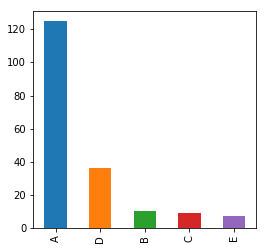

In [109]:
bar_strDim(df_venn, 'Emissions Quality Flag')

# Clean up and save

## Remove CDP2017 columns

In [110]:
col_order = list(df_venn)

In [111]:
df_venn2016 = df_venn.drop([s for s in col_order if '2017' in s], 1)

In [112]:
col_names = list(df_venn2016)

In [113]:
idx=0
for cname in list(df_venn2016):
    if '(CDP2016)' in cname:
        df_venn2016.rename(columns = {cname:cname.replace('CDP2016', 'CDP')}, inplace = True)
    else:
        df_venn2016.rename(columns = {cname:cname + ' (CDP)'}, inplace = True)

In [114]:
df_venn2016.shape

(187, 31)

In [115]:
df_venn2016.to_csv('DATA/INTERMEDIATE_FILES/cdp_with_quality_flags.tsv', sep='\t', encoding='utf-8')

# Continue to Methods2_CH4corrections.ipynb